# Predicting Success of Car Insurance Cold Calls

## Introduction

There is a methodology that has been used within many industries to reach out to consumers to ask for their business which has stood the test of time. I'm referring to the classic cold call of course; employees are asked to call people of which they have no prior connection in most cases to ask for their business out of the blue. I've made many cold calls myself while working in the insurance industry in a previous role, where cold calling was used commonly.

As someone who had to make cold calls, I know how nerve-wracking it can be to make calls to random people and I know how irritated people on the receiving end can be as well. Using a data set provided by an undisclosed bank which also provides insurance services, I was interested to know if there were certain characteristics that would lead to greater cold-calling success.

### Import relevant libraries and data for exploration and initial analysis

I begin by importing some commonly used Python libraries for data analysis as well as the data itself.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Import relevant data and set the index to Id
df_train = pd.read_csv('.\carinsurance\carInsurance_train.csv')
df_test = pd.read_csv('.\carinsurance\carInsurance_test.csv')

df_train.set_index('Id', inplace=True)
df_test.set_index('Id', inplace=True)

df_train.head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


Below are some details about the data provided by Technische Universität München:

#### Feature Overview

| Feature | Description | Example |
|:---|:---|:---|
| Id | Unique ID number. Predictions file should countain this feature. | "1" ... "5000" |
| Age | Age of the client | |
| Job | Job of the client. | "admin.", "blue-collar", etc. |
| Marital | Marital status of the client | "divorced", "married", "single" |
| Education | Education level of the client | "primary", "secondary", etc. |
| Default | Has credit in default? | "yes" - 1,"no" - 0 |
| Balance | Average yearly balance, in USD | |
| HHInsurance | Is household insured | "yes" - 1,"no" - 0 |
| CarLoan | Has the client a car loan | "yes" - 1,"no" - 0 |
| Communication | Contact communication type | "cellular", "telephone", “NA” |
| LastContactMonth | Month of the last contact | "jan", "feb", etc. |
| LastContactDay | Day of the last contact | |
| CallStart | Start time of the last call (HH:MM:SS) | 12:43:15 |
| CallEnd | End time of the last call (HH:MM:SS) | 12:43:15 |
| NoOfContacts | Number of contacts performed during this campaign for this client | |
| DaysPassed | Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | |
| PrevAttempts | Number of contacts performed before this campaign and for this client | |
| Outcome | Outcome of the previous marketing campaign | "failure", "other", "success", “NA” |
| CarInsurance | Has the client subscribed a CarInsurance? | "yes" - 1,"no" - 0 |

Let's take a look at some initial details about the data.

In [3]:
df_train.describe()

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [4]:
df_train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,11:48:25,10:22:30
freq,893,2304,1988,2831,1049,437,3,3


There are 4,000 client records in this dataset. I found it interesting that the range of ages were for people of nearly all ages (18 to 95), with a majority of people being in the 30 to 50 age range. The PDF provided with more details about the data doesn't clarify on if Balance refers to average total loan principal balance for that client, average total deposit balance or something else, but in either case it seems unusual to have a negative balance. Also it appears there may be outliers for Balance given the distribution of values, since 75% of clients have a balance of 1,619 or less yet the max is a balance of 98,417. LastContactDay looks to be spread out evenly throughout each respective month at first glance. I feel bad for the person who was contacted 43 times, but it looks like most people were only contacted three times or less.

We can see from the describe method for object class features that we have some missing values to handle for Job, Education, Communication, and Outcome.

I check the test data set quick to make sure trends shown in the training data generally apply.

In [5]:
df_test.describe()

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,0.0
mean,41.473000,0.013000,1398.298000,0.513000,0.12100,15.546000,2.50800,51.653000,0.806000,NaN
std,12.051577,0.113331,2660.408024,0.500081,0.32629,8.370541,2.57732,109.024855,2.034331,NaN
min,18.000000,0.000000,-1980.000000,0.000000,0.00000,1.000000,1.00000,-1.000000,0.000000,NaN
25%,32.000000,0.000000,114.750000,0.000000,0.00000,8.000000,1.00000,-1.000000,0.000000,NaN
50%,39.000000,0.000000,517.500000,1.000000,0.00000,15.000000,2.00000,-1.000000,0.000000,NaN
75%,49.250000,0.000000,1609.750000,1.000000,0.00000,21.000000,3.00000,-1.000000,0.000000,NaN
max,92.000000,1.000000,41630.000000,1.000000,1.00000,31.000000,34.00000,586.000000,20.000000,NaN


In [6]:
df_test.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,995,1000,953,779,1000,243,1000,1000
unique,11,3,3,2,12,3,986,980
top,management,married,secondary,cellular,may,failure,17:59:19,16:17:06
freq,221,594,501,698,269,111,2,2


In [7]:
# Quick check for Balance outliers
df_train['Balance'].sort_values().tail()

Id
2308    38279
3305    43074
3252    45248
164     52587
1743    98417
Name: Balance, dtype: int64

In [8]:
# Check data types for different variables
df_train.dtypes

Age                  int64
Job                 object
Marital             object
Education           object
Default              int64
Balance              int64
HHInsurance          int64
CarLoan              int64
Communication       object
LastContactDay       int64
LastContactMonth    object
NoOfContacts         int64
DaysPassed           int64
PrevAttempts         int64
Outcome             object
CallStart           object
CallEnd             object
CarInsurance         int64
dtype: object

Now I'll take a better look at the data by creating a few simple visuals.

Text(0, 0.5, 'Number of Clients')

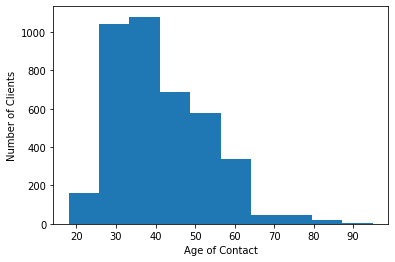

In [9]:
# Visualize distribution of Age
plt.hist(df_train['Age'], bins=10)
plt.xlabel('Age of Contact')
plt.ylabel('Number of Clients')

As noted earlier, most clients contacted were between the ages of 30-50, but it looks like there's a large drop in the number of contacts for those older than 40.

Text(0, 0.5, 'Number of Clients')

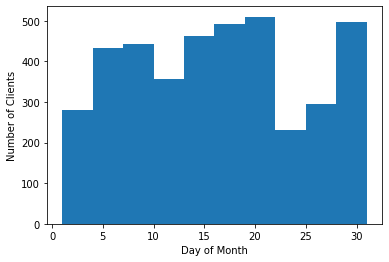

In [10]:
# Visualize distribution of LastContactDay
plt.hist(df_train['LastContactDay'])
plt.xlabel('Day of Month')
plt.ylabel('Number of Clients')

The LastContactDay is spread out relatively evenly as mentioned previously, however it looks less calls were made between the 22nd and 25th days of the month. 

An interesting field provided in this dataset is the number of days passed since the client was last contacted during a prior campaign (DaysPassed). What makes it interesting is that the data signifies a person as not having been previously contacted as a -1. This poses a problem, especially if I were to consider doing some sort of normalization.

To handle this, I decided to skip ahead a bit and bin the DaysPassed values to make it easier to use records of clients who haven't been used before (which is a vast majority of this dataset).

In [11]:
# Assign DaysPassed to two bins: Previously Contacted and Not Previously Contacted
df_train['DaysPassed_bins'] = pd.cut(df_train['DaysPassed'], [-1.1, 0, 854], labels=['No Prior Contact', 'Previously Contacted'])

# Do the same for test data set (for later use)
df_test['DaysPassed_bins'] = pd.cut(df_test['DaysPassed'], [-1.1, 0, 854], labels=['No Prior Contact', 'Previously Contacted'])

df_train.groupby('DaysPassed_bins').DaysPassed.count()

DaysPassed_bins
No Prior Contact        3042
Previously Contacted     958
Name: DaysPassed, dtype: int64

Before starting some feature engineering, I take a quick look at a correlation matrix to see if any fields are highly correlated with one another.

In [12]:
# Correlation matrix
corr = df_train.corr()
corr.style.background_gradient(cmap='viridis').set_precision(2)

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
Age,1,0.0037,0.094,-0.18,-0.012,0.014,0.029,-0.017,-0.0025,0.039
Default,0.0037,1,-0.054,-0.015,0.12,0.027,0.03,-0.033,-0.032,-0.04
Balance,0.094,-0.054,1,-0.072,-0.082,0.016,-0.0052,-0.0021,0.0013,0.042
HHInsurance,-0.18,-0.015,-0.072,1,0.088,-0.024,-0.0059,0.081,0.027,-0.2
CarLoan,-0.012,0.12,-0.082,0.088,1,0.011,0.021,-0.042,-0.021,-0.092
LastContactDay,0.014,0.027,0.016,-0.024,0.011,1,0.14,-0.074,-0.073,-0.061
NoOfContacts,0.029,0.03,-0.0052,-0.0059,0.021,0.14,1,-0.1,-0.057,-0.11
DaysPassed,-0.017,-0.033,-0.0021,0.081,-0.042,-0.074,-0.1,1,0.5,0.14
PrevAttempts,-0.0025,-0.032,0.0013,0.027,-0.021,-0.073,-0.057,0.5,1,0.15
CarInsurance,0.039,-0.04,0.042,-0.2,-0.092,-0.061,-0.11,0.14,0.15,1


Looks like there's not much correlation among the provided fields here.

## Feature Engineering and Data Prep

Before doing any additional data exploration, I thought it would be best to do some feature engineering to derive some additional insight from the data provided that will hopefully prove to be beneficial when modeling.

I begin by determining the length of each cold call, as I imagine this would be important when determining the level of success of a call. I also decided to look at the hour of the day in which the call was made because I believe this would have a significant impact on the cold call success. For example, perhaps a cold call is not as successful during typical work hours.

### Handling Missing Values

In [13]:
# Check number of missing values
df_train.isnull().sum()

Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
DaysPassed_bins        0
dtype: int64

In [14]:
# Fill missing education and job values with mode
edmode_train = df_train['Education'].mode()
df_train['Education'].fillna(edmode_train[0], inplace=True)
edmode_test = df_test['Education'].mode()
df_test['Education'].fillna(edmode_test[0], inplace=True)


jobmode_train = df_train['Job'].mode()
df_train['Job'].fillna(jobmode_train[0], inplace=True)
jobmode_test = df_test['Job'].mode()
df_test['Job'].fillna(jobmode_test[0], inplace=True)

# Fill NA Outcome values with 'No Prior Contact'
df_train['Outcome'].fillna('No Prior Contact', inplace=True)
df_test['Outcome'].fillna('No Prior Contact', inplace=True)

# Drop Communication - Not clear on the difference between telephone and cellular
df_train.drop('Communication', axis=1, inplace=True)
df_test.drop('Communication', axis=1, inplace=True)

I decided to drop the Communication field since it is unclear what the difference between 'cellular' and 'telephone' communication types are from the data dictionary provided.

In [15]:
# Make sure all missing values were taken care of
df_train.isnull().sum()

Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
DaysPassed_bins     0
dtype: int64

In [16]:
# Remove record with outlier for Balance
df_train = df_train[df_train['Balance'] < 90000]

# Bin Balance for easy use in modeling
df_train['Balance_bins'] = pd.cut(df_train['Balance'], [-3058.1, 0, 2000, 52587], labels=['Neg Bal', 'Bal 2000 or less', 'Bal 2000 or more'])
df_train.groupby('Balance_bins').Balance.count()

Balance_bins
Neg Bal              574
Bal 2000 or less    2582
Bal 2000 or more     843
Name: Balance, dtype: int64

In [17]:
# Make sure bins made for Balance have a similar distribution for test data set
df_test['Balance_bins'] = pd.cut(df_test['Balance'], [-3058.1, 0, 2000, 52587], labels=['Neg Bal', 'Bal or less 2000', 'Bal or more 2000'])
df_test.groupby('Balance_bins').Balance.count()

Balance_bins
Neg Bal             135
Bal or less 2000    662
Bal or more 2000    203
Name: Balance, dtype: int64

In [18]:
# Determine call length (in minutes)
df_train['CallStart'] = pd.to_datetime(df_train['CallStart'])
df_train['CallEnd'] = pd.to_datetime(df_train['CallEnd'])
df_train['CallLength'] = ((df_train['CallEnd'] - df_train['CallStart'])/np.timedelta64(1,'m')).astype(float)
df_test['CallStart'] = pd.to_datetime(df_test['CallStart'])
df_test['CallEnd'] = pd.to_datetime(df_test['CallEnd'])
df_test['CallLength'] = ((df_test['CallEnd'] - df_test['CallStart'])/np.timedelta64(1,'m')).astype(float)

# Find the hour in which the call was made
df_train['CallStartHour'] = df_train['CallStart'].dt.hour
df_test['CallStartHour'] = df_test['CallStart'].dt.hour
df_train.head()

# Drop CallStart and CallEnd
df_train.drop(['CallStart', 'CallEnd'], axis=1, inplace=True)
df_test.drop(['CallStart', 'CallEnd'], axis=1, inplace=True)

I was curious to see how the last contact day could play a role in the cold calls success, having up to 31 possible days in a month makes things a little complicated. I tried to simplify things by determining whether or not a phone call was made in the first or second half of the month instead, where a 1 signifies the last contact was made during the first half of the month and a 0 signifies the last contact was made during the second half of the month. I used the 15th as my halfway point.

In [19]:
# Determine if the last contact was made during the first or second half of the month, using the 15th as the halfway point
df_train['LastContactFirstH'] = df_train['LastContactDay'].where(df_train['LastContactDay'] <= 15, 1)
df_train['LastContactFirstH'].where(df_train['LastContactFirstH'] > 15, 0, inplace=True)

df_test['LastContactFirstH'] = df_test['LastContactDay'].where(df_test['LastContactDay'] <= 15, 1)
df_test['LastContactFirstH'].where(df_test['LastContactFirstH'] > 15, 0, inplace=True)

# Drop LastContactDay to avoid redundancy
df_train.drop('LastContactDay', axis=1, inplace=True)
df_test.drop('LastContactDay', axis=1, inplace=True)

I also wanted to simplify the Age variable a bit given the large range of ages contacted. I decided to assign each client to an age bin, which allows me to treat Age as more of a categorical variable.

In [20]:
# Create age bins
df_train['Age_bins'] = pd.qcut(df_train['Age'], 4, labels=['18 to 32', '33 to 39', '40 to 49', '50 and older'])
df_train.groupby('Age_bins').Age.count()

Age_bins
18 to 32        1037
33 to 39        1034
40 to 49         988
50 and older     940
Name: Age, dtype: int64

In [21]:
# Mimic bins made for training data set in the testing data set
df_test['Age_bins'] = pd.cut(df_test['Age'], [18, 32, 39, 49, 95], labels=['18 to 32', '33 to 39', '40 to 49', '50 and older'])
df_test.groupby('Age_bins').Age.count()

Age_bins
18 to 32        253
33 to 39        268
40 to 49        228
50 and older    250
Name: Age, dtype: int64

In [22]:
# Drop fields that are no longer necessary
df_train.drop(['Age', 'DaysPassed', 'Balance'], axis=1, inplace=True)
df_test.drop(['Age', 'DaysPassed', 'Balance'], axis=1, inplace=True)
df_train.head()

,Job,Marital,Education,Default,HHInsurance,CarLoan,LastContactMonth,NoOfContacts,PrevAttempts,Outcome,CarInsurance,DaysPassed_bins,Balance_bins,CallLength,CallStartHour,LastContactFirstH,Age_bins
Id,,,,,,,,,,,,,,,,,
1,management,single,tertiary,0,1,0,jan,2,0,No Prior Contact,0,No Prior Contact,Bal 2000 or less,1.166667,13,0,18 to 32
2,blue-collar,married,primary,0,1,0,may,5,0,No Prior Contact,0,No Prior Contact,Bal 2000 or less,3.083333,14,0,18 to 32
3,management,single,tertiary,0,1,0,jun,1,1,failure,1,Previously Contacted,Bal 2000 or less,5.666667,16,0,18 to 32
4,student,single,primary,0,1,0,may,2,0,No Prior Contact,1,No Prior Contact,Bal 2000 or less,13.650000,12,0,18 to 32
5,management,married,tertiary,0,0,0,jun,1,0,No Prior Contact,0,No Prior Contact,Bal 2000 or more,3.200000,14,0,18 to 32


### One-Hot Encoding

At this point I'm ready to one-hot encode the categorical variables that are not already in a flag type of format. I decided to use one-hot encoding to try and avoid any data type issues. For example, I could have assigned each record in LastContactMonth a number between 1 and 12 to signify the number month in the year but my model might assume this is a nominal variable where a higher number has more significant meaning to the outcome.

In [23]:
# Create dummy variables and append to original data set
df_train = pd.get_dummies(df_train, columns=['Job', 'Marital', 'Education', 'LastContactMonth', 'Outcome', 'DaysPassed_bins', 'Age_bins', 'Balance_bins'])
df_test = pd.get_dummies(df_test, columns=['Job', 'Marital', 'Education', 'LastContactMonth', 'Outcome', 'DaysPassed_bins', 'Age_bins', 'Balance_bins'])

df_train.head()

,Default,HHInsurance,CarLoan,NoOfContacts,PrevAttempts,CarInsurance,CallLength,CallStartHour,LastContactFirstH,Job_admin.,...,Outcome_success,DaysPassed_bins_No Prior Contact,DaysPassed_bins_Previously Contacted,Age_bins_18 to 32,Age_bins_33 to 39,Age_bins_40 to 49,Age_bins_50 and older,Balance_bins_Neg Bal,Balance_bins_Bal 2000 or less,Balance_bins_Bal 2000 or more
Id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,2,0,0,1.166667,13,0,0,...,0,1,0,1,0,0,0,0,1,0
2,0,1,0,5,0,0,3.083333,14,0,0,...,0,1,0,1,0,0,0,0,1,0
3,0,1,0,1,1,1,5.666667,16,0,0,...,0,0,1,1,0,0,0,0,1,0
4,0,1,0,2,0,1,13.650000,12,0,0,...,0,1,0,1,0,0,0,0,1,0
5,0,0,0,1,0,0,3.200000,14,0,0,...,0,1,0,1,0,0,0,0,0,1


## Modeling

Now for the fun stuff: the modeling! I plan to try a few different types of Tree/Forest models given the categorical nature of the outcome I'm trying to predict. I also try a logistic regression model to try and determine the probability that someone will purchase car insurance after a cold call.

In [24]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']

In [25]:
# Establish train_test_split
X = df_train.drop(['CarInsurance'], axis=1)
y = df_train['CarInsurance']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

### Evaluating Model Accuracy

Since this is a classification modeling situation, I needed to give some thought about how to evaluate model accuracy. It would be easy to look at a confusion matrix of the results and take the proportion of correct predictions over incorrect predictions as the model's overall accuracy, but it's a bit more complicated than that for classification cases.

Part of what makes evaluating a classification model more complicated than evaluating a model that predicts a continous variable is determining the cost of certain outcomes. For example if I was trying to predict if someone had a terminal illness, most people would agree that there is less cost in predicting that someone has the illness when they actually don't than to predict that they don't have the illness when they actually do. In situations such as this, the outcome could literally mean the difference between life or death for the individual in question. I would want to assign more weight in my model evaluation to the outcomes in which a person actually has a terminal illness as a result. This would both improve the evaluation of my model more than normal for predicting that a person has the terminal illness when they actually do (true positive), and hurt the model evaluation more than normal for predicting that a person doesn't have the illness when the actually do (false negative).

The result of a client's decision to purchase car insurance or not after a cold call, thankfully, does not result in a life or death situation. For my analysis however, I wanted to focus the evaluation of my models on the ability to predict successes, which in this case is defined as a person purchasing car insurance as the result of a cold call campaign.

Another thing to keep in mind is the distribution of options for the target variable. In the example of predicting if a person has a terminal illness, if the illness is only found in 1% of people and this is reflected in the test data used to evaluate my model, my model could predict that nobody in the test set had a terminal illness and the typical accuracy metric would suggest an accuracy of 99%. An accuracy of 99% looks pretty good at first glance, but you can see where this can become a major problem if not investigated further.

In the case of this project you will see that the train_test_split gave me 1,200 records for evaluation, where 712 of them resulted in the client not purchasing car insurance and 488 of them resulted in the client purchasing car insurance as a result of the cold call campaign. Although the distribution of outcomes isn't equal, I don't believe it will pose much of an issue in this case. 

In [26]:
# Create function for cross validation - Will utilize in next iteration of project
# def get_score(model, X, y):

#     scores = cross_val_score(model, X, y,
#                                  cv=5,
#                                  scoring='recall')
    
#     return scores

In [27]:
# Establish target labels for easier understanding of classification reports
# Success = Purchased car insurance, Failure = Did not purchase car insurance
target_labels = ['Failure', 'Success']

For my model evaluation, I decided to select a 'best' model by looking at the Precision, Recall, F1-Score, and general accuracy for each model type. If there was not a clear 'best' model, the decision would be made by looking more closely at the Precision, Recall and F1-Score results.

              precision    recall  f1-score   support

     Failure      0.790     0.815     0.802       712
     Success      0.717     0.684     0.700       488

    accuracy                          0.762      1200
   macro avg      0.753     0.750     0.751      1200
weighted avg      0.760     0.762     0.761      1200

Default = 0.0023666341740345535
HHInsurance = 0.05003517411223891
CarLoan = 0.018210107544899077
NoOfContacts = 0.04219969166775228
PrevAttempts = 0.02525400845819846
CallLength = 0.3865390897505522
CallStartHour = 0.0516563257273786
LastContactFirstH = 0.0
Job_admin. = 0.006858093958390068
Job_blue-collar = 0.0056128399650192526
Job_entrepreneur = 0.008510661420207054
Job_housemaid = 0.0048639595405882575
Job_management = 0.006582264504647638
Job_retired = 0.008525535378672101
Job_self-employed = 0.0060039033273412016
Job_services = 0.01317646883589144
Job_student = 0.00821503364941016
Job_technician = 0.008300678245392492
Job_unemployed = 0.004713294314514968
Mar

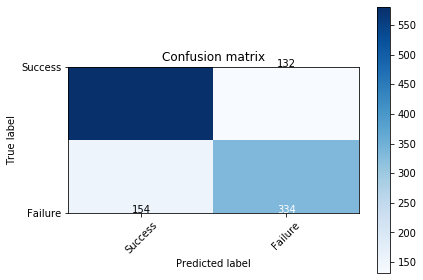

In [28]:
# Decision Tree
dtree = DecisionTreeClassifier(random_state=0)

dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_val)

print(classification_report(y_val, dtree_pred, digits=3, target_names=target_labels))

cm_dtree = confusion_matrix(y_val, dtree_pred)
plot_confusion_matrix(cm_dtree, class_names)
for name, importance in zip(X.columns, dtree.feature_importances_):
    print(name, "=", importance)

C:\Users\KevinJMiller\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

     Failure      0.795     0.865     0.829       712
     Success      0.774     0.674     0.721       488

    accuracy                          0.787      1200
   macro avg      0.784     0.770     0.775      1200
weighted avg      0.786     0.787     0.785      1200

Default = 0.0016876438211023898
HHInsurance = 0.03303169812944577
CarLoan = 0.012474641241489682
NoOfContacts = 0.04876140876041198
PrevAttempts = 0.02130662900239492
CallLength = 0.35833279471561663
CallStartHour = 0.06175960373232728
LastContactFirstH = 0.0
Job_admin. = 0.009169073094812524
Job_blue-collar = 0.013389900844134885
Job_entrepreneur = 0.0042243593303124575
Job_housemaid = 0.003493067827218726
Job_management = 0.01386954791083516
Job_retired = 0.0067831119843008705
Job_self-employed = 0.003559889318437875
Job_services = 0.006601757770832954
Job_student = 0.009138185347698469
Job_technician = 0.013256533859031718
Job_unemployed = 0.007976379098629527
M

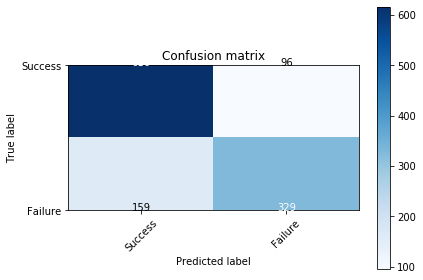

In [29]:
# Random Forest
rforest = RandomForestClassifier(random_state=0)

rforest.fit(X_train, y_train)
rforest_pred = rforest.predict(X_val)

print(classification_report(y_val, rforest_pred, digits=3, target_names=target_labels))

cm_rforest = confusion_matrix(y_val, rforest_pred)
plot_confusion_matrix(cm_rforest, class_names)
for name, importance in zip(X.columns, rforest.feature_importances_):
    print(name, "=", importance)

The Random Forest model performed better in nearly every category compared to the Decision Tree model, so the Random Forest is considered the best at this point.

              precision    recall  f1-score   support

     Failure      0.858     0.851     0.855       712
     Success      0.785     0.795     0.790       488

    accuracy                          0.828      1200
   macro avg      0.822     0.823     0.822      1200
weighted avg      0.829     0.828     0.828      1200

Default = 0.0
HHInsurance = 0.0781242
CarLoan = 0.02265795
NoOfContacts = 0.015050735
PrevAttempts = 0.025292026
CallLength = 0.10266498
CallStartHour = 0.009385759
LastContactFirstH = 0.0
Job_admin. = 0.011891357
Job_blue-collar = 0.029135723
Job_entrepreneur = 0.013579374
Job_housemaid = 0.0
Job_management = 0.014723281
Job_retired = 0.0073898383
Job_self-employed = 0.011279902
Job_services = 0.009738443
Job_student = 0.03040444
Job_technician = 0.00706124
Job_unemployed = 0.0
Marital_divorced = 0.0046839206
Marital_married = 0.012680909
Marital_single = 0.0019628708
Education_primary = 0.005997228
Education_secondary = 0.009612068
Education_tertiary = 0.01025916

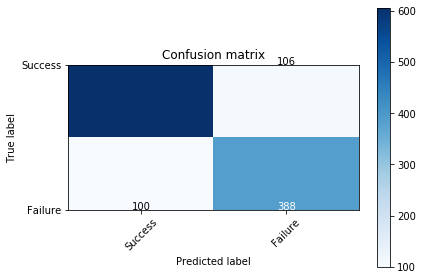

In [30]:
# XGBoost
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

print(classification_report(y_val, xgb_pred, digits=3, target_names=target_labels))

cm_xgb = confusion_matrix(y_val, xgb_pred)
plot_confusion_matrix(cm_xgb, class_names)
for name, importance in zip(X.columns, xgb.feature_importances_):
    print(name, "=", importance)

The XGBoost model scored better in every category except for the recall of Failures, defined as a person not purchasing car insurance in this case. XGBoost is currently the best model with an general accuracy of 82.8%.

C:\Users\KevinJMiller\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

     Failure      0.819     0.881     0.848       712
     Success      0.804     0.715     0.757       488

    accuracy                          0.813      1200
   macro avg      0.811     0.798     0.803      1200
weighted avg      0.813     0.813     0.811      1200



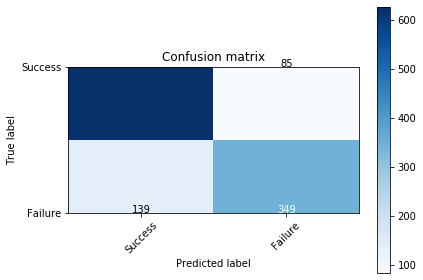

In [31]:
# Logistic Regression
lreg = LogisticRegression()

lreg.fit(X_train, y_train)
lreg_pred = lreg.predict(X_val)

print(classification_report(y_val, lreg_pred, digits=3, target_names=target_labels))

cm_lreg = confusion_matrix(y_val, lreg_pred)
plot_confusion_matrix(cm_lreg, class_names)

# Unsure how to list features and their importances at this time. Something to add in a future iteration.

Comparing the results of the XGBoost to the Logistic Regression model is a little more difficult, since the Logistic Regression model appears to provide a better Precision score for Successes, Recall score for Failures. However, the XGBoost model had better F1-scores for both Successes and Failures.

## Conclusion



After testing four different types of models, I determined that the XGBoost classification model performed the best for this use case as it provided the best general accuracy and F1-scores from both a Success and Failure perspective. My XGBoost model was able to predict whether or not a client would purchase car insurance as the result of a cold call campaign with 82.8% accuracy. The top five most important features used to fit the model were:

- Outcome_success - previous cold call campaign was successful with client
- CallLength - length of the cold call
- HHInsurance - household is insured
- LastContactMonth_may - client was last contacted in the month of May
- LastContactMonth_july - client was last contacted in the month of July

As you will have likely noticed, the importance weights for the five features listed above ranged from about 0.117 to 0.034 (out of 1.00), which aren't very high. This is largely due to the fact that there were fifty features to consider after one hot encoding. The top five important features do make sense for the most part however. For example if the bank in question was successful in selling a product to a client during a prior cold call campaign it likely means that the client is open to hearing about new products and services. A longer call length also makes sense as an important predictor as a shorter call length signifies a short conversation, which normally means the client wasn't interested in hearing about the product, and a longer conversation likely signifies a client was receiving more information about the product or setting up service. Most insurance providers include some sort of bundling discount where having multiple types of insurance with one provider lowers the price a client pays which would likely attract clients to want car insurance as well. As for the last contact months of May and July, I'm not entirely sure why that would be significant given the contact day for each client was different for the cold call campaign analyzed here. If the contact day for each client was the same, it would be easier to make some inferences.

There are obviously some flaws to this model as I'm using this as a way to practice some new skills. In future iterations of this project I'd like to perform cross validation aid in the selection of better hyperparameters. I'd also like to explore some feature selection techniques to reduce the number of features to fit the model with to those that are deemed truly significant. I plan to learn more about data vizualization with Python, so I hope to update some existing vizualizations in this project and possibly add more meaningful visualizations as well.